# ECE381K Final Project

The goal of this project is to communicate over a real baseband channel with impulse response:
$$
h[n] = \begin{bmatrix}
    0.8037 & 0.7209 & -0.3179 & -0.3395 & -0.2455 & -0.0897 & -0.1079 & 0.2267 & -0.1602
\end{bmatrix}^T
$$

We will analyze given a fixed transmit filter and matched receiver filter $g_{TX}[n] = g_{RX}[n] = \frac{1}{\sqrt{T}}\delta[n]$, fixed signal energy per dimension $\bar{\mathcal{E}_s} = 1$, and fixed noise power $\frac{N_0}{2}=0.15$

In [1]:
import numpy as np
import scipy.fft as fft
import matplotlib.pyplot as plt

import sys
sys.path.append('./src')

import utils, encoders, OFDM

In [2]:
h = np.array([0.8037, 0.7209, -0.3179,-0.3395, -0.2455, -0.0897, -0.1079, 0.2267, -0.1062])
E_bar = 1
No = 0.3

## ISI Channel Fundamentals

First we determine $q[n]$ and plot its frequency response

First, we find the pulse response
$$
g_{TX}[n] = \frac{1}{\sqrt{T}}\delta[n] \\
p[n] = h[n] \ast g_{TX}[n] \\
\Longrightarrow p[n] = h[n] \\
$$

We can then find an expression for $q[n]$
$$
\begin{equation*}
    \begin{split}
    q[n] &\overset{\Delta}{=} T \cdot p[n] \ast p^*[-n] / ||p||\\
    q[n] &= T \cdot h[n] \ast h^*[-n] / ||p||
    \end{split}
\end{equation*}
$$

For this project, we will assume T = 1

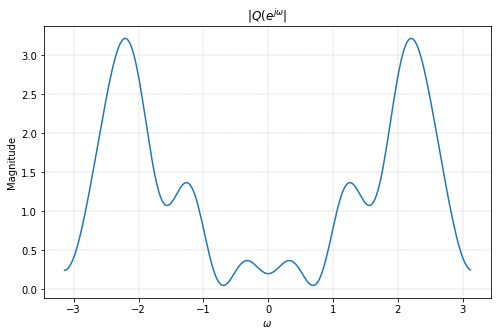

In [3]:
__n__ = 256 # Adjust to change the smoothness of the produced figure

p = h
mag_p = p @ p

q = np.convolve(h, np.conj(h[::-1])) / np.sqrt(mag_p)
Q = fft.fft(q, __n__)

fig = plt.figure(figsize=(8, 5))
plt.plot(np.arange(-np.pi, np.pi, 2*np.pi/__n__), np.abs(Q))
plt.title('$|Q(e^{j\omega}|$')
plt.ylabel('Magnitude')
plt.xlabel('$\omega$')
plt.grid(True, ls='--', lw=0.4)
plt.show()


Next we determine the matched filter bound $SNR_{MFB}$ for this channel

$$
SNR_{MFB} \overset{\Delta}{=} \frac{\bar{\mathcal{E}_s} \cdot ||p||^2}{\frac{N_0}{2}}
$$

It is important for us to note that the inner product $||p^2|| = p^Tp$

In [4]:
snr_mfb = E_bar * mag_p * 2 / No
print(f'SNR(mfb) = {snr_mfb:.2f} ({utils.lin_to_db(snr_mfb):.2f} db)')

SNR(mfb) = 10.16 (10.07 db)


Now we can find the associated data rate for a given probability.
For example, we take $P_e < 10^{-4}$, which corresponds to a gap of $r = 6.6$ in dB.

Using the Shannon Limit for baseband channels, $b \leq \frac{1}{2}log_2(1 + \frac{SNR}{r})$, we find:

In [8]:
gap = 6.6

b = np.log2(1 + snr_mfb/utils.db_to_lin(6.6)) / 2
print(f'The maximum spectral efficiency we can expect on this channel is: {b:.4f} bps/Hz')

The maximum spectral efficiency we can expect on this channel is: 0.8443 bps/Hz


We can find the expected probability of error is we are to send symbols over this channel without equalization. If we transmit with 2PAM, we wil have 

$P_e = P_b \leq Q(\sqrt{SINR})$

We have 

$SINR = \frac{S}{ISI + \sigma^2}$

$S = |q[0]|^2 \cdot \bar{\mathcal{E}_s}$

$ISI = \sum_{k\neq0}{|q[k]|^2 \cdot \bar{\mathcal{E}_s}}$

$\sigma^2 = \frac{N_0}{2}$

In [9]:
c = len(q) // 2 # Center index

S = E_bar * q[c]
ISI = E_bar * np.sum((np.concatenate((q[:c], q[c+1:])) ** 2))
sig2 = No/2

SINR = S / (ISI + sig2)

Pe = utils.qfunc(np.sqrt(SINR))

print(f'The expected probability of error for symbol by symbol detection with no equalization is: {Pe:.5f}')

The expected probability of error for symbol by symbol detection with no equalization is: 0.14746


Now we can simulate transmission over this exact channel and determine an empirical probability of error for 100k bits

In [7]:
n_bits = 10 ** 5

pam = encoders.MPAM(M=2)
b = utils.generate_bits(n_bits)

symbols = pam.encode_bits(b)

signal = np.convolve(symbols, h, 'full')[:len(symbols)]
signal += np.sqrt(No/2) * np.random.randn(*signal.shape)

b_hat = pam.decode_symbols(signal)

empirical_pe = utils.probability_of_bit_error(b, b_hat)
print(f'The empirical probability of error we simulate is: {empirical_pe:.4f}')

The empirical probability of error we simulate is: 0.2365


## ZF and MMSE FIR Equalization

Here I design 33 tap ZF and MMSE FIR equalizers to improve performance

## OFDM

